<a href="https://colab.research.google.com/github/wave307/FLO/blob/main/flo_app/AI_Agent_for_Structured_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing all the required packages

In [ ]:
# !pip install streamlit -q
# !pip install pyngrok -q
# !pip install langchain -q
# !pip install langchain_openai -q
# !pip install langchain_community -q
# !pip install pymssql -q
# !pip install faiss-cpu -q
# !npm install localtunnel -q
# !pip install sqlalchemy -q
# !pip install langgraph -q
# !pip install grandalf -q

Importing packages and modules required

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_community.utilities import SQLDatabase
from langchain_community.vectorstores import FAISS
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_openai import OpenAIEmbeddings
from langchain_community.agent_toolkits import create_sql_agent
from langchain_core.prompts.few_shot import FewShotPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain_core.prompts.chat import MessagesPlaceholder
import os
import pandas as pd
import sqlalchemy as sa
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import json
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Any, Annotated, Dict, Optional, Sequence, TypedDict
from typing_extensions import TypedDict
import operator
import functools
from langgraph.graph import END, StateGraph, START
from typing import Union, Literal
from pydantic import BaseModel
from langchain.agents import AgentType, Tool, initialize_agent
from langchain_core.callbacks.stdout import StdOutCallbackHandler
from langchain_core.messages import BaseMessage, AIMessage, AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.output_parsers import StrOutputParser
import datetime

In [ ]:
datetime.date.today().strftime("%d-%B-%Y")

'07-November-2024'

Instantiating the LLM model

In [ ]:
open_ai_key = "<Key>"
os.environ['OPENAI_API_KEY'] = open_ai_key
llm = ChatOpenAI(model_name='gpt-4o-mini',
                     api_key=open_ai_key,
                     temperature = 0.3)

Setting up the system prompt for the sql agent and examples

In [ ]:
examples = [
    {"input": "Give me average monthly electricity prices of all sectors for all years", "query": "SELECT AVG(ALL Sectors) from electricity_prices;"},
]

system_prefix = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct T-SQL/ Microsoft SQL query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Try to answer the question in a full detailed manner with all the information required in it.

If the question does not seem related to the database, just return "I don't know" as the answer.

Here are some examples of user inputs and their corresponding SQL queries:"""

In [ ]:
def set_prompts():
    example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    OpenAIEmbeddings(),
    FAISS,
    k=5,
    input_keys=["input"],)

    few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=PromptTemplate.from_template(
        "User input: {input}\nSQL query: {query}"
    ),
    input_variables=["input"],
    prefix= system_prefix,
    suffix="",)

    full_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate(prompt=few_shot_prompt),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ])
    return full_prompt

Initialize the agent for use



In [ ]:
def initialize_agent():
    cred = {'server': 'database-flo-event.crk0kymw6bal.eu-north-1.rds.amazonaws.com',
     'port' : '1433',
     'database': 'FLO_DB',
     'username': 'admin',
     'password': 'WIZSzRdP0uKdbuMwLzOS'}

    connection_url = URL.create(
            "mssql+pymssql",
            username=cred['username'],
            password=cred['password'],
            host=cred['server'],
            database=cred['database'],
        )
    full_prompt = set_prompts()
    engine = create_engine(connection_url)
    flo_db = SQLDatabase(engine)
    agent = create_sql_agent(
                llm=llm,
                db=flo_db,
                prompt=full_prompt,
                verbose=False,
                agent_type="openai-tools",
            )
    return agent

agent = initialize_agent()

Start of graph creation -->

Supervisor prompt and listing out the agents and optional paths to use

In [ ]:
prompt_message="""You are a supervisor tasked with managing a conversation between the following workers: {members}. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. If the conversation is over, respond with 'FINISH'.
    - **Sql_agent**: Use this worker for tasks that involve:
        - Answering questions that are related to electricity price , electricity sales or electricity consumption.
        - Handling queries that require specific data analysis, calculations, or retrieval from structured SQL databases, particularly when it involves electricity related metrics.
    - **general_agent**: Use this worker for general query answering.
Decision Criteria:
- If the query involves structured data points related to electricity and requires a calculation or database lookup, direct it to the **Sql_agent**.
- In cases where both agents could be relevant, prioritize the **Sql_agent** for anything related to electricity.
Example Decision Flow:
- Query: "Give me average monthly electricity prices of all sectors for all years." -> **Sql_agent**
- Query: "Percentage of electriciry geneartion or production by all means in year 2021" -> **Sql_agent**
- Query: "What is the national animal of India" -> **general_agent**
- Query: "Write me a python code for 'Hello World'" -> **general_agent**
"""
system_prompt = prompt_message
members = ["Sql_agent", "general_agent"]
options = ["FINISH"] + members


RouteResponseNextType = Union[Literal["FINISH"] , Literal["Sql_agent"], Literal["general_agent"]]

class RouteResponse(BaseModel):
    next: RouteResponseNextType


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


In [ ]:
class LLMManager:
    def __init__(self):
        self.llm = llm

    def invoke(self, prompt: ChatPromptTemplate, **kwargs) -> str:
        messages = prompt.format_messages(**kwargs)
        response = self.llm.invoke(messages)
        return response.content
llm_manager = LLMManager()

Prompts and instructions for graph creation and storing it in key value form


In [ ]:
barGraphIntstruction = """
  Where data is: {
    labels: string[]
    values: {data: number[], label: string}[]
  }

// Examples of usage:
Each label represents a column on the x axis.
Each array in values represents a different entity.

Here we are looking at average income for each month.
1. data = {
  labels: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'],
  values: [{data:[21.5, 25.0, 47.5, 64.8, 105.5, 133.2], label: 'Income'}],
}

Here we are looking at the performance of american and european players for each series. Since there are two entities, we have two arrays in values.
2. data = {
  labels: ['series A', 'series B', 'series C'],
  values: [{data:[10, 15, 20], label: 'American'}, {data:[20, 25, 30], label: 'European'}],
}
"""

horizontalBarGraphIntstruction = '''
  Where data is: {
    labels: string[]
    values: {data: number[], label: string}[]
  }

// Examples of usage:
Each label represents a column on the x axis.
Each array in values represents a different entity.

Here we are looking at average income for each month.
1. data = {
  labels: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'],
  values: [{data:[21.5, 25.0, 47.5, 64.8, 105.5, 133.2], label: 'Income'}],
}

Here we are looking at the performance of american and european players for each series. Since there are two entities, we have two arrays in values.
2. data = {
  labels: ['series A', 'series B', 'series C'],
  values: [{data:[10, 15, 20], label: 'American'}, {data:[20, 25, 30], label: 'European'}],
}

'''

lineGraphIntstruction = '''

  Where data is: {
  xValues: number[] | string[]
  yValues: { data: number[]; label: string }[]
}

// Examples of usage:

Here we are looking at the momentum of a body as a function of mass.
1. data = {
  xValues: ['2020', '2021', '2022', '2023', '2024'],
  yValues: [
    { data: [2, 5.5, 2, 8.5, 1.5]},
  ],
}

Here we are looking at the performance of american and european players for each year. Since there are two entities, we have two arrays in yValues.
2. data = {
  xValues: ['2020', '2021', '2022', '2023', '2024'],
  yValues: [
    { data: [2, 5.5, 2, 8.5, 1.5], label: 'American' },
    { data: [2, 5.5, 2, 8.5, 1.5], label: 'European' },
  ],
}
'''

pieChartIntstruction = '''

  Where data is: {
    labels: string
    values: number
  }[]

// Example usage:
 data = [
        { id: 0, value: 54.81, label: 'Coal' },
        { id: 1, value: 60.1, label: 'Neuclear' },
        { id: 2, value: 20.01, label: 'Solar' },
      ],
'''

scatterPlotIntstruction = '''
Where data is: {
  series: {
    data: { x: number; y: number; id: number }[]
    label: string
  }[]
}

// Examples of usage:
1. Here each data array represents the points for a different entity.
We are looking for correlation between amount spent and quantity bought for men and women.
data = {
  series: [
    {
      data: [
        { x: 100, y: 200, id: 1 },
        { x: 120, y: 100, id: 2 },
        { x: 170, y: 300, id: 3 },
      ],
      label: 'Men',
    },
    {
      data: [
        { x: 300, y: 300, id: 1 },
        { x: 400, y: 500, id: 2 },
        { x: 200, y: 700, id: 3 },
      ],
      label: 'Women',
    }
  ],
}

2. Here we are looking for correlation between the height and weight of players.
data = {
  series: [
    {
      data: [
        { x: 180, y: 80, id: 1 },
        { x: 170, y: 70, id: 2 },
        { x: 160, y: 60, id: 3 },
      ],
      label: 'Players',
    },
  ],
}

// Note: Each object in the 'data' array represents a point on the scatter plot.
// The 'x' and 'y' values determine the position of the point, and 'id' is a unique identifier.
// Multiple series can be represented, each as an object in the outer array.
'''


graph_instructions = {
    "bar": pieChartIntstruction,
    "horizontal_bar": horizontalBarGraphIntstruction,
    "line": lineGraphIntstruction,
    "pie": pieChartIntstruction,
    "scatter": scatterPlotIntstruction
}

Defining functions for node creation in graph

To choose if graph creation is possible

In [ ]:
def choose_visualization(state):
    """Choose an appropriate visualization for the data."""
    question = state['question']
    results = state['answer']
    prompt = ChatPromptTemplate.from_messages([
        ("system", '''
You are an AI assistant that recommends appropriate data visualizations. Based on the user's question, SQL query, and query results, suggest the most suitable type of graph or chart to visualize the data. If no visualization is appropriate, indicate that.

Available chart types and their use cases:
- Bar Graphs: Best for comparing categorical data or showing changes over time when categories are discrete and the number of categories is more than 2. Use for questions like "What are the sales figures for each product?" or "How does the population of cities compare? or "What percentage of each city is male?"
- Horizontal Bar Graphs: Best for comparing categorical data or showing changes over time when the number of categories is small or the disparity between categories is large. Use for questions like "Show the revenue of A and B?" or "How does the population of 2 cities compare?" or "How many men and women got promoted?" or "What percentage of men and what percentage of women got promoted?" when the disparity between categories is large.
- Scatter Plots: Useful for identifying relationships or correlations between two numerical variables or plotting distributions of data. Best used when both x axis and y axis are continuous. Use for questions like "Plot a distribution of the fares (where the x axis is the fare and the y axis is the count of people who paid that fare)" or "Is there a relationship between advertising spend and sales?" or "How do height and weight correlate in the dataset? Do not use it for questions that do not have a continuous x axis."
- Pie Charts: Ideal for showing proportions or percentages within a whole. Use for questions like "What is the market share distribution among different companies?" or "What percentage of the total revenue comes from each product?"
- Line Graphs: Best for showing trends and distributionsover time. Best used when both x axis and y axis are continuous. Used for questions like "How have website visits changed over the year?" or "What is the trend in temperature over the past decade?". Do not use it for questions that do not have a continuous x axis or a time based x axis.

Consider these types of questions when recommending a visualization:
1. Aggregations and Summarizations (e.g., "What is the average electricity consumption by month?" - Line Graph)
2. Comparisons (e.g., "Compare the electricity generation with coal vs neuclear over the last year." - Line Graph)
3. Plotting Distributions (e.g., "Plot a distribution of the electricity generation using vaiorus means" - Scatter Plot)
4. Trends Over Time (e.g., "What is the trend in the consumption of electricity over the past year?" - Line Graph)
5. Proportions (e.g., "What is the average percenatge of electricity generation by all over the past year?" - Pie Chart)
6. Change Over Time(e.g, "What is the average electricity consumption per month in the past year?" - Bar Graph)

Provide your response in the following format:
Recommended Visualization: [Chart type or "None"]. ONLY use the following names: bar, horizontal_bar, line, pie, scatter, none
Reason: [Brief explanation for your recommendation]
'''),
        ("human", '''
User question: {question}
Query results: {results}

Recommend a visualization:'''),
    ])

    response = llm_manager.invoke(prompt, question=question, results=results)

    lines = response.split('\n')
    visualization = lines[0].split(': ')[1]
    reason = lines[1].split(': ')[1]

    return {"visualization": visualization, "visualization_reason": reason}

Format the data if there can be a graph plotted

In [ ]:
class DataFormatter:
    def __init__(self):
        self.llm_manager = LLMManager()

    def format_data_for_visualization(self, state: dict) -> dict:
        """Format the data for the chosen visualization type."""
        visualization = state['visualization'].strip()
        results = state['answer']
        question = state['question']

        if visualization == "none":
            return {"formatted_data_for_visualization": None}

        if visualization == "scatter":
            try:
                return self._format_scatter_data(results)
            except Exception as e:
                return self._format_other_visualizations(visualization, question, results)

        if visualization == "bar" or visualization == "horizontal_bar":
            try:
                return self._format_bar_data(results, question)
            except Exception as e:
                return self._format_other_visualizations(visualization, question, results)

        if visualization == "line":
            try:
                return self._format_line_data(results, question)
            except Exception as e:
                return self._format_other_visualizations(visualization, question, results)

        return self._format_other_visualizations(visualization, question, results)

    def _format_line_data(self, results, question):
        if isinstance(results, str):
            results = eval(results)

        if len(results[0]) == 2:

            x_values = [str(row[0]) for row in results]
            y_values = [float(row[1]) for row in results]

            # Use LLM to get a relevant label
            prompt = ChatPromptTemplate.from_messages([
                ("system", "You are a data labeling expert. Given a question and some data, provide a concise and relevant label for the data series."),
                ("human", "Question: {question}\n Data (first few rows): {data}\n\nProvide a concise label for this y axis. For example, if the data is the sales figures over time, the label could be 'Sales'. If the data is the population growth, the label could be 'Population'. If the data is the revenue trend, the label could be 'Revenue'."),
            ])
            label = self.llm_manager.invoke(prompt, question=question, data=str(results[:2]))

            formatted_data = {
                "xValues": x_values,
                "yValues": [
                    {
                        "data": y_values,
                        "label": label.strip()
                    }
                ]
            }
        elif len(results[0]) == 3:

            # Group data by label
            data_by_label = {}
            x_values = []

            # Get a list of unique labels
            labels = list(set(item2 for item1, item2, item3 in results
                              if isinstance(item2, str) and not item2.replace(".", "").isdigit() and "/" not in item2))

            # If labels are not in the second position, check the first position
            if not labels:
                labels = list(set(item1 for item1, item2, item3 in results
                                  if isinstance(item1, str) and not item1.replace(".", "").isdigit() and "/" not in item1))

            for item1, item2, item3 in results:
                # Determine which item is the label (string not convertible to float and not containing "/")
                if isinstance(item1, str) and not item1.replace(".", "").isdigit() and "/" not in item1:
                    label, x, y = item1, item2, item3
                else:
                    x, label, y = item1, item2, item3


                if str(x) not in x_values:
                    x_values.append(str(x))
                if label not in data_by_label:
                    data_by_label[label] = []
                data_by_label[label].append(float(y))
                print(labels)
                for other_label in labels:
                    if other_label != label:
                        if other_label not in data_by_label:
                            data_by_label[other_label] = []
                        data_by_label[other_label].append(None)

            # Create yValues array
            y_values = [
                {
                    "data": data,
                    "label": label
                }
                for label, data in data_by_label.items()
            ]

            formatted_data = {
                "xValues": x_values,
                "yValues": y_values,
                "yAxisLabel": ""
            }

            # Use LLM to get a relevant label for the y-axis
            prompt = ChatPromptTemplate.from_messages([
                ("system", "You are a data labeling expert. Given a question and some data, provide a concise and relevant label for the y-axis."),
                ("human", "Question: {question}\n Data (first few rows): {data}\n\nProvide a concise label for the y-axis. For example, if the data represents sales figures over time for different categories, the label could be 'Sales'. If it's about population growth for different groups, it could be 'Population'."),
            ])
            y_axis_label = self.llm_manager.invoke(prompt, question=question, data=str(results[:2]))

            # Add the y-axis label to the formatted data
            formatted_data["yAxisLabel"] = y_axis_label.strip()

        return {"formatted_data_for_visualization": formatted_data}

    def _format_scatter_data(self, results):
        if isinstance(results, str):
            results = eval(results)

        formatted_data = {"series": []}

        if len(results[0]) == 2:
            formatted_data["series"].append({
                "data": [
                    {"x": float(x), "y": float(y), "id": i+1}
                    for i, (x, y) in enumerate(results)
                ],
                "label": "Data Points"
            })
        elif len(results[0]) == 3:
            entities = {}
            for item1, item2, item3 in results:
                # Determine which item is the label (string not convertible to float and not containing "/")
                if isinstance(item1, str) and not item1.replace(".", "").isdigit() and "/" not in item1:
                    label, x, y = item1, item2, item3
                else:
                    x, label, y = item1, item2, item3
                if label not in entities:
                    entities[label] = []
                entities[label].append({"x": float(x), "y": float(y), "id": len(entities[label])+1})

            for label, data in entities.items():
                formatted_data["series"].append({
                    "data": data,
                    "label": label
                })
        else:
            raise ValueError("Unexpected data format in results")

        return {"formatted_data_for_visualization": formatted_data}


    def _format_bar_data(self, results, question):
        if isinstance(results, str):
            results = eval(results)

        if len(results[0]) == 2:
            # Simple bar chart with one series
            labels = [str(row[0]) for row in results]
            data = [float(row[1]) for row in results]

            # Use LLM to get a relevant label
            prompt = ChatPromptTemplate.from_messages([
                ("system", "You are a data labeling expert. Given a question and some data, provide a concise and relevant label for the data series."),
                ("human", "Question: {question}\nData (first few rows): {data}\n\nProvide a concise label for this y axis. For example, if the data is the sales figures for products, the label could be 'Sales'. If the data is the population of cities, the label could be 'Population'. If the data is the revenue by region, the label could be 'Revenue'."),
            ])
            label = self.llm_manager.invoke(prompt, question=question, data=str(results[:2]))

            values = [{"data": data, "label": label}]
        elif len(results[0]) == 3:
            # Grouped bar chart with multiple series
            categories = set(row[1] for row in results)
            labels = list(categories)
            entities = set(row[0] for row in results)
            values = []
            for entity in entities:
                entity_data = [float(row[2]) for row in results if row[0] == entity]
                values.append({"data": entity_data, "label": str(entity)})
        else:
            raise ValueError("Unexpected data format in results")

        formatted_data = {
            "labels": labels,
            "values": values
        }

        return {"formatted_data_for_visualization": formatted_data}

    def _format_other_visualizations(self, visualization, question, results):
        instructions = graph_instructions[visualization]
        prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a Data expert who formats data according to the required needs.
            You are given the question asked by the user and its answer in Result and the format you need to format the Result in."""),
            ("human", '''For the given question: {question}

            and Result: {results}

            Use the following example to structure the data in Result: {instructions}.
            Just give the json string. Do not format it'''),
        ])
        response = self.llm_manager.invoke(prompt, question=question, results=results, instructions=instructions)

        try:
            formatted_data_for_visualization = json.loads(response)
            return {"formatted_data_for_visualization": formatted_data_for_visualization}
        except json.JSONDecodeError:
            return {"error": "Failed to format data for visualization", "raw_response": response}

Creating agent state class - this state will pass accross all the nodes in the graph

In [ ]:
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str
    question: str
    answer:Annotated[str, operator.add]
    visualization: Annotated[str, operator.add]
    visualization_reason: Annotated[str, operator.add]
    formatted_data_for_visualization: Dict[str, Any]
    error: str

Creating all the agent node functions

In [ ]:
def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(RouteResponse)
    )
    return supervisor_chain.invoke(state)


def agent_node(state, agent, name):
    query = state["messages"][-1].content
    response = agent.invoke({"input": query})
    return {"messages": [AIMessage(content=response['output'], name=name)], "question" :query, "answer":response['output']}

def simple_agent_node(state, name):
    if "question" in state:
        query = state["question"]
    else:
        query = state["messages"][-1].content

    prompt_sa = PromptTemplate(
        template="""You are an expert in answering questions based on your knowledge.
        Here is the Question:
        {question}

        Provide your answer in Text format and no preamble please.
        """,
        input_variables=["question"],
    )
    simple_chain = prompt_sa | llm | StrOutputParser()
    response_op = simple_chain.invoke({"question": query})
    return {"messages": [AIMessage(content=response_op, name=name)], "question": query,
            "answer": response_op}

sql_node = functools.partial(agent_node, agent=agent, name="Sql_agent")
general_node = functools.partial(simple_agent_node, name="general_agent")
data_formatter = DataFormatter()

Creating graph edges and defining nodes

In [ ]:
workflow = StateGraph(AgentState)
workflow.add_node("Sql_agent", sql_node)
workflow.add_node("general_agent", general_node)
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("choose_visualization", choose_visualization)
workflow.add_node("format_data_for_visualization", data_formatter.format_data_for_visualization)
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.add_edge("Sql_agent", "choose_visualization")
workflow.add_edge("choose_visualization", "format_data_for_visualization")
workflow.add_edge("format_data_for_visualization", "supervisor")
workflow.add_edge("general_agent", "supervisor")
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()


This is the agentic graph created

In [ ]:
print(graph.get_graph().draw_ascii())

                                         +-----------+                                    
                                         | __start__ |                                    
                                         +-----------+                                    
                                                *                                         
                                                *                                         
                                                *                                         
                                        +------------+                                    
                                      **| supervisor |****                                
                                ******  +------------+    ******                          
                         *******        ..          .           *******                   
                   ******             ..             ..                ******             

Function to execute the graph

In [ ]:
def get_answers(query, graph=graph):
    answer = None
    graph_type = None
    graph_values = None
    for s in graph.stream({"messages": [HumanMessage(content=query)]}):
        print("@"*100)
        print(s)
        print("@"*100)
        if 'Sql_agent' in s:
            answer = s['Sql_agent']["answer"]
        elif 'general_agent' in s:
            answer = s['general_agent']["answer"]
        if 'choose_visualization' in s:
            graph_type = s['choose_visualization']["visualization"]
            graph_type = graph_type.strip()
        if 'format_data_for_visualization' in s:
            graph_values = s["format_data_for_visualization"]["formatted_data_for_visualization"]
    return answer, graph_type, graph_values

In [ ]:
answer, graph_type, graph_values = get_answers("Which months have, historically, experienced demand surges, with demand exceeding total state generation over the past 5 years?")
print(answer)
print("*"*100)
print(graph_type)
print(graph_values)

Over the past 5 years, the months that have historically experienced demand surges, with demand exceeding total state generation, are primarily in September. Here are the details:

1. **September 2020**
   - Total Generation: 320.97
   - Total Demand: 322.55

2. **September 2021**
   - Total Generation: 335.27
   - Total Demand: 336.44

3. **September 2022**
   - Total Generation: 339.01
   - Total Demand: 340.54

4. **September 2023**
   - Total Generation: 345.96
   - Total Demand: 346.13

5. **September 2024**
   - Total Generation: 343.31
   - Total Demand: 345.62

6. **September 2025**
   - Total Generation: 354.54
   - Total Demand: 356.80

These results indicate a consistent pattern of demand exceeding generation in September across the years analyzed.
****************************************************************************************************
line
{'xValues': ['2020', '2021', '2022', '2023', '2024', '2025'], 'yValues': [{'data': [322.55, 336.44, 340.54, 346.13, 345.62, 

In [ ]:
answer, graph_type, graph_values = get_answers("What is the average electricy consumption per month in the past year? Also give me a bar chart.")
print(answer)
print("*"*100)
print(graph_type)
print(graph_values)

The average electricity consumption per month in the past year is as follows:

| Month | Average Consumption (All Sectors) |
|-------|------------------------------------|
| January   | 343.64 kWh                       |
| February  | 302.32 kWh                       |
| March     | 300.63 kWh                       |
| April     | 287.67 kWh                       |
| May       | 312.99 kWh                       |
| June      | 351.60 kWh                       |
| July      | 397.91 kWh                       |
| August    | 397.53 kWh                       |
| September | 351.21 kWh                       |
| October   | 318.03 kWh                       |
| November  | 300.74 kWh                       |
| December  | 319.98 kWh                       |

This data shows the average monthly electricity consumption across all sectors for each month over the past year. 

Unfortunately, I cannot create a bar chart directly, but you can use this data to create one using any data visualization t

In [ ]:
answer, graph_type, graph_values = get_answers("Give me a python code for generating Fibonacci sequence.")
print(answer)
print("*"*100)
print(graph_type)
print(graph_values)

```python
def fibonacci(n):
    sequence = []
    a, b = 0, 1
    for _ in range(n):
        sequence.append(a)
        a, b = b, a + b
    return sequence

# Example usage:
n = 10  # Change this value for more or fewer Fibonacci numbers
print(fibonacci(n))
```
****************************************************************************************************
None
None


Printing the answer and showing the plotted graph

This is your answer:
Over the past 5 years, the months that have historically experienced demand surges, where the total demand exceeded the total state generation, are primarily in September. Here are the details:

1. **September 2020**
   - Total Demand: 322.55
   - Total Generation: 320.97

2. **September 2021**
   - Total Demand: 336.44
   - Total Generation: 335.27

3. **September 2022**
   - Total Demand: 340.54
   - Total Generation: 339.01

4. **September 2023**
   - Total Demand: 346.13
   - Total Generation: 345.96

5. **September 2024**
   - Total Demand: 345.62
   - Total Generation: 343.31

6. **September 2025**
   - Total Demand: 356.80
   - Total Generation: 354.54

These figures indicate a consistent trend of increased demand in September, surpassing the generation capacity during these years.
****************************************************************************************************


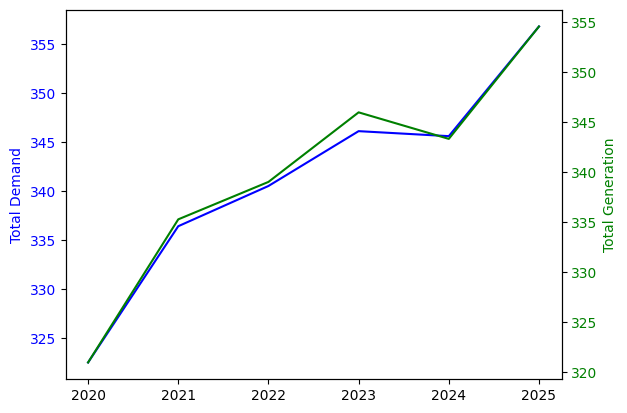

In [ ]:
print("This is your answer:")
print(answer)
print("*"*100)

if graph_type == 'line':
    fig, ax1 = plt.subplots()
    x = graph_values["xValues"]
    yvalues = graph_values["yValues"]
    y = yvalues[0]['data']
    y_label = yvalues[0]['label']
    ax1.plot(x, y, color='blue', label='Close Price')
    ax1.set_xlabel('')
    ax1.set_ylabel(y_label, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    if len(yvalues) > 1:
        # Create a twin axis for the High_minus_Low variable
        ax2 = ax1.twinx()
        ax2.plot(x,yvalues[1]['data'], color='green', label='High - Low')
        ax2.set_ylabel( yvalues[1]['label'], color='green')
        ax2.tick_params(axis='y', labelcolor='green')
    plt.show()
elif graph_type == 'pie' or graph_type == 'bar':
    fig, ax = plt.subplots()
    labels = []
    values = []
    for i in graph_values:
        labels.append(i["label"])
        values.append(abs(i["value"]))
    ax.bar(labels, values)
    # show plot
    plt.xticks(rotation='vertical')
    plt.show()

Now we will create a vanilla chat application which can talk to the data

Importing and configuring NgRock

In [ ]:
from pyngrok import ngrok
!ngrok config add-authtoken <ngrok key>

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


starting streamlit application

In [ ]:
!streamlit run app.py &>logs.txt &
!pgrep streamlit

79880


In [ ]:
!pgrep streamlit
#!kill 78249

Publishing the streamlit application

In [ ]:
public_url = ngrok.connect("http://localhost:8501")
public_url

<NgrokTunnel: "https://c288-34-169-71-121.ngrok-free.app" -> "http://localhost:8501">

Writing app.py
